### Chapter 4: Descriptors of Chemical Graphs Across Scale

§ Will cover both local graph descriptors (edge distributions), cyclicity, extended scale descriptors like geodesics, etc. This will be similar to what was written by the author in: Clark, A. E. Intermolecular Network Theory: A General Approach for Understanding the Structural and Dynamic Properties of Liquids and Solutions. In Annual Reports in Computational Chemistry; Dixon, D. A., Ed.; 2015; pp 313–359

In [3]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d
from IPython.display import display
from IPython.display import Image

In [4]:
def getLammpsXYZdata(snapshot, filePath):
    header_df = pd.read_csv(filePath, sep=' ', nrows=1, header=None)
    
    numAtoms=header_df.loc[0, 0]
    headerRows=2
    rowStart = (snapshot)*numAtoms+(snapshot+1)*headerRows
   
    snapshot_df = pd.read_csv(filePath, sep=' ', skiprows=rowStart, nrows=numAtoms, header=None)
    snapshot_df.columns = ['AtomType','X','Y', 'Z']
    return snapshot_df

In [5]:
filePath="C:/Users/dpope/OneDrive - Washington State University (email.wsu.edu)/Documents/Projects/Book/MDvisualization/lmp.xyz"
snapshot_df = getLammpsXYZdata(1, filePath)
print(snapshot_df)


    AtomType         X         Y        Z
0          O  11.91940  10.19330  6.26740
1          H  12.75390   9.59258  6.39780
2          H  11.80990  10.13300  5.25142
3          O  13.98080   1.90477  3.40816
4          H  13.83670   2.89592  3.17398
..       ...       ...       ...      ...
379        H  13.69440   5.98993  2.98947
380        H  15.13090   6.52446  3.12730
381        O   9.65532  11.61570  8.64450
382        H  10.15300  12.20310  7.94132
383        H   9.97654  10.63080  8.53797

[384 rows x 4 columns]


In [6]:
import networkx as nx

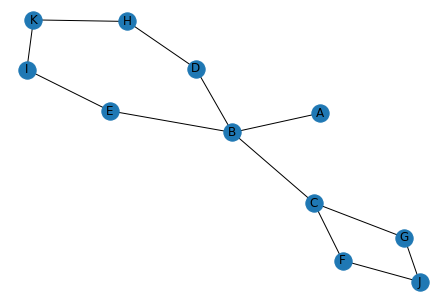

In [7]:
G=nx.Graph()

nodeList=['A','B','C','D','E','F','G','H','I','J','K']
for i in range(len(nodeList)):
    G.add_node(nodeList[i], label=nodeList[i])
#     G.nodes[nodeList[i]]['parent']=-1
#     G.nodes[nodeList[i]]['visited']=False

G.add_edge('A','B')
G.add_edge('B','C')
G.add_edge('B','D')
G.add_edge('B','E')
G.add_edge('C','F')
G.add_edge('C','G')
G.add_edge('D','H')
G.add_edge('E','I')
G.add_edge('F','J')
G.add_edge('G','J')
G.add_edge('H','K')
G.add_edge('I','K')


Gorig=G.copy()

nx.draw(G, with_labels=True)

plt.show()

# Breadth First Algorithm
## Detect cycle in graph

In [7]:
from collections import deque 

def BFS(Graph, origNode):

    G=Graph

    for i in range(len(nodeList)):
        G.nodes[nodeList[i]]['parent']=-1
        G.nodes[nodeList[i]]['visited']=False
    
    nodeQueue = deque()
    if len(list(G.adj['A'])) < 2:
        return 'False'
    #mark current Node as visited and add to search queue
    G.nodes[nodeList[0]]['visited']=True
    nodeQueue.append(nodeList[0])
      
    while nodeQueue != deque([]): 
#         print(nodeQueue)
        # Dequeue a vertex from queue and print it 
        currentNode = nodeQueue.popleft()
#         print(currentNode)
        #Get all adjacent nodes of current vertex
        #If site has not been visited, set to visited
        #Set vertex parent to exclude from cycle check
        adjNodeList=list(G.adj[currentNode])
#         print(adjNodeList)
        for adjNode in adjNodeList:
            if not G.nodes[adjNode]['visited']:
                G.nodes[adjNode]['visited']=True
                G.nodes[adjNode]['parent']=currentNode
                nodeQueue.append(adjNode)
            elif G.nodes[currentNode]['parent'] != adjNode:
                return 'True'    
    return 'False'

In [8]:
BFS(G,'A')
len(G.nodes)

11

# Dijkstra Algorithm
## Shortest distance between two vertices

- 1) Create a set sptSet (shortest path tree set) that keeps track of vertices included in shortest path tree, i.e., whose minimum distance from source is calculated and finalized. Initially, this set is empty.
- 2) Assign a distance value to all vertices in the input graph. Initialize all distance values as INFINITE. Assign distance value as 0 for the source vertex so that it is picked first.
- 3) While sptSet doesn’t include all vertices
    - .a) Pick a vertex u which is not there in sptSet and has minimum distance value.
    - .b) Include u to sptSet.
    - .c) Update distance value of all adjacent vertices of u. To update the distance values,  iterate through all adjacent vertices. For every adjacent vertex v, if sum of distance value of u (from source) and weight of edge u-v, is less than the distance value of v, then update the distance value of v.

In [9]:
# Dijkstra Algorithm


def Dijkstra(G, originNode):

    SPTset = deque()
    nodeSet = deque()
    nodeSet.extend(list(G.nodes))

    for i in nodeSet:
        G.nodes[i]['parent']=-1
        G.nodes[i]['dist']=float('inf')

    G.nodes[originNode]['dist']=0

    while len(SPTset) != len(G.nodes):
        minDistanceNode = nodeSet[0]
        for i in nodeSet:
            if G.nodes[i]['dist'] < G.nodes[minDistanceNode]['dist']:
                minDistanceNode = i
        SPTset.append(minDistanceNode)
        nodeSet.remove(minDistanceNode)
        for i in list(G.adj[minDistanceNode]):
            G.nodes[i]['parent']=minDistanceNode
            newDist=G.nodes[minDistanceNode]['dist']+1
            if newDist < G.nodes[i]['dist']:
                G.nodes[i]['dist']=G.nodes[minDistanceNode]['dist']+1
    
    return G  

# Minimum Cycle

- Get adjacent vertices (u) from vertice (s)
- Remove vertice (s) from graph
- From subgraph, employ Dijkstra algorithm to find minimum distance between all pairs of adjacent vertices(u,v)
- Retain value of smallest distance pair
- Smallest cycle size is the smallest pair distance plus 2 from the edges of the removed vertice (s)

In [10]:
def minCycle(Gorig, originNode):
    G=Gorig.copy()
    minCycle=float('inf')
    adjPairSet=deque()
    adjPairSet.extend(list(G.adj[originNode]))
    G.remove_node(originNode)

    for i in adjPairSet:
        for j in adjPairSet:
            if i != j and i < j:
                G=Dijkstra(G,i)
                if G.nodes[j]['dist'] < minCycle:
                    minCycle=G.nodes[j]['dist']
#                 print(i,j,G.nodes[j]['dist'])
    return minCycle+2

## Degree of circulation in Complex Networks

Average Cycle Coeffecient

- average of Local Cycle Coefficient

$R=\langle r_i\rangle$

Local Cycle Coefficient

- average of inverse of smallest cycle size (S) of each vertice pair (u,v) of vertice (s)

$r_i=\frac{2}{k_i(k_i-1)}\sum_{\langle bc\rangle}\frac{1}{S^i_{lm}}$

In [11]:
#Local Cycle Coefficient

#Get adjacent vertices (u) from vertice (s)
#Remove vertice (s) from graph
#From subgraph, employ Dijkstra algorithm to find minimum distance between all pairs
#of adjacent vertices(u,v)

def LCC(G, s):
    S=0 
    H=G.copy()
    minCycle=float('inf')
    adjPairSet=deque()
    adjPairSet.extend(list(H.adj[s]))
    H.remove_node(s)
    
    for u in adjPairSet:
        for v in adjPairSet:
            if u != v and u < v:
                H=Dijkstra(H,u)
                S+=1/(H.nodes[v]['dist']+2)
                
    return S

# Average Cycle Coeffecient

# Obtain LCC for each vertice s and return average value

def ACC(G):
    R=0
    for s in G.nodes:
        if len(G.adj[s])>1:
            k=len(G.adj[s])
            R+=2/(k*(k-1))*LCC(G,s)
    return R/len(G.nodes)

ACC(G)

0.15404040404040406

In [12]:
#apply to lmp.xyz
#apply to water vappor?

#implement random vertice search in equilibrium data set

#port Andrew's data

In [46]:
# def getLammpsXYZdata(snapshot, filePath):
#     header_df = pd.read_csv(filePath, sep=' ', nrows=1, header=None)
    
#     numAtoms=header_df.loc[0, 0]
#     headerRows=2
#     rowStart = (snapshot)*numAtoms+(snapshot+1)*headerRows
   
#     snapshot_df = pd.read_csv(filePath, sep=' ', skiprows=rowStart, nrows=numAtoms, header=None)
#     snapshot_df.columns = ['AtomType','X','Y', 'Z']
#     return snapshot_df

def getLammpsXYZdata(snapshot, filePath):
    header_df = pd.read_csv(filePath, sep=' ', nrows=1, header=None)
    
    numAtoms=header_df.loc[0, 0]
    headerRows=2
    rowStart = (snapshot)*numAtoms+(snapshot+1)*headerRows
   
    snapshot_df = pd.read_csv(filePath, sep=' ', skiprows=rowStart, nrows=384, header=None)
#     snapshot_df = pd.read_csv(filePath, sep=' ', header = None, skiprows=1000, chunksize=1000)
    snapshot_df.columns = ['AtomType','X','Y', 'Z']
    return snapshot_df

filePath="C:/Users/dpope/OneDrive - Washington State University (email.wsu.edu)/Documents/Projects/Book/MDvisualization/lmp.xyz"
snapshot_df = getLammpsXYZdata(1, filePath)
print(snapshot_df)

    AtomType         X         Y        Z
0          O  11.91940  10.19330  6.26740
1          H  12.75390   9.59258  6.39780
2          H  11.80990  10.13300  5.25142
3          O  13.98080   1.90477  3.40816
4          H  13.83670   2.89592  3.17398
..       ...       ...       ...      ...
379        H  13.69440   5.98993  2.98947
380        H  15.13090   6.52446  3.12730
381        O   9.65532  11.61570  8.64450
382        H  10.15300  12.20310  7.94132
383        H   9.97654  10.63080  8.53797

[384 rows x 4 columns]


In [14]:
filePath="C:/Users/dpope/OneDrive - Washington State University (email.wsu.edu)/Documents/Projects/Book/MDvisualization/lmp.xyz"
snapshot_df = getLammpsXYZdata(1, filePath)
print(snapshot_df)

    AtomType         X         Y        Z
0          O  11.91940  10.19330  6.26740
1          H  12.75390   9.59258  6.39780
2          H  11.80990  10.13300  5.25142
3          O  13.98080   1.90477  3.40816
4          H  13.83670   2.89592  3.17398
..       ...       ...       ...      ...
379        H  13.69440   5.98993  2.98947
380        H  15.13090   6.52446  3.12730
381        O   9.65532  11.61570  8.64450
382        H  10.15300  12.20310  7.94132
383        H   9.97654  10.63080  8.53797

[384 rows x 4 columns]


In [15]:
G=nx.Graph()
nodeList_O=[]
nodeList_H=[]
num=384

# Create Graph Nodes
for i in range(num):
    if (snapshot_df.loc[i, 'AtomType']=='O'):
        G.add_node(i, label=snapshot_df.loc[i, 'AtomType']+str(i),node_color="tab:red")
        nodeList_O.append(i)
    if (snapshot_df.loc[i, 'AtomType']=='H'):
        G.add_node(i, label=snapshot_df.loc[i, 'AtomType']+str(i), size=5, node_color="tab:white")
        nodeList_H.append(i)
        
#Create Graph Edges based on hydrogen bond criteria
for i in range(num):
    for j in range(num):
        if i!=j and snapshot_df.loc[i, 'AtomType']=='O' and snapshot_df.loc[j, 'AtomType']=='H':
            distance = (
                (snapshot_df.loc[i, 'X']-snapshot_df.loc[j, 'X'])**2
                +(snapshot_df.loc[i, 'Y']-snapshot_df.loc[j, 'Y'])**2
                +(snapshot_df.loc[i, 'Z']-snapshot_df.loc[j, 'Z'])**2
            )**(0.5)
            if distance < 2.6:
                G.add_edge(i,j)

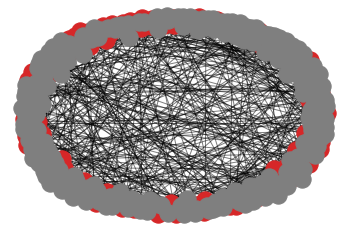

In [16]:
pos = nx.spring_layout(G,k=100, scale=10)  # positions for all nodes

nx.draw_networkx_nodes(G,pos,nodelist=nodeList_O,node_color="tab:red")
nx.draw_networkx_nodes(G,pos,nodelist=nodeList_H,node_color="tab:gray")
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

plt.axis("off")
plt.show()

In [52]:
import time
start_time = time.time()
print(ACC(G))
print("--- %s seconds ---" % (time.time() - start_time))



0.07505368522295613
--- 86.06734919548035 seconds ---


In [35]:
import random

#run Local Cycle Coefficient n times for random vertice
#for each vertice update Average Cycle Coefficient
#continue until ACC converges or until x cycles

#randomized Average Cycle Coefficient
def rACC(G):


    sum=0
    convergenceCriteria=10**(-3)
    rACClist=deque()
    rACClist.append(-1)
    convergenceData=deque()
    convergenceData.append(-1)
    R=0
    for s in range(200):
        r=random.randint(0, len(G.nodes)-1)
        if len(G.adj[r])>1:
            k=len(G.adj[r])
            R+=2/(k*(k-1))*LCC(G,r)
        rACClist.append(R/(s+1))
        convergenceData.append(rACClist[s+1]-rACClist[s])
    return rACClist, convergenceData


In [67]:
rACClist,convergenceData = rACC(G)



(0.0, 0.1)

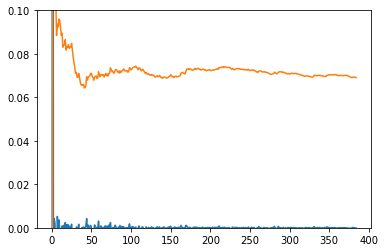

In [39]:
plt.plot(convergenceData)
plt.plot(rACClist)
plt.ylim((0, 0.1)) 

In [62]:
def getPDBdata(numAtoms, snapshot, filePath):
    footerRows=1
    rowStart = (snapshot)*(numAtoms)
   
    snapshot_df = pd.read_csv(filePath, sep = "\s+|\t+|\s+\t+|\t+\s+", skiprows=0, nrows=numAtoms, header=None)
#     snapshot_df = pd.read_csv(filePath, sep=' ', header = None, skiprows=1000, chunksize=1000)
    snapshot_df.columns = ['Atom','AtomNumber','Label', 'Sol', 'Molecule', 'X', 'Y', 'Z', '', '', 'AtomType']
    return snapshot_df

filePath="C:/Users/dpope/OneDrive - Washington State University (email.wsu.edu)/Documents/Projects/Book/MDvisualization/water_vapor_traj.pdb"
snapshot_df = getPDBdata(1068, 100, filePath)
print(snapshot_df)

      Atom  AtomNumber Label  Sol  Molecule       X       Y       Z            \
0     ATOM           1    OW  SOL         1   6.147  14.738  48.535  1.0  0.0   
1     ATOM           2   HW1  SOL         1   5.585  15.575  48.659  1.0  0.0   
2     ATOM           3   HW2  SOL         1   6.119  14.531  47.551  1.0  0.0   
3     ATOM           4    OW  SOL         2  17.220  15.017  39.446  1.0  0.0   
4     ATOM           5   HW1  SOL         2  16.906  15.030  40.440  1.0  0.0   
...    ...         ...   ...  ...       ...     ...     ...     ...  ...  ...   
1063  ATOM        1064   HW1  SOL       355   1.692  20.428  53.885  1.0  0.0   
1064  ATOM        1065   HW2  SOL       355   3.258  20.710  54.248  1.0  0.0   
1065  ATOM        1066    OW  SOL       356  19.101  21.358  53.298  1.0  0.0   
1066  ATOM        1067   HW1  SOL       356  18.941  20.890  52.443  1.0  0.0   
1067  ATOM        1068   HW2  SOL       356  18.494  20.885  53.993  1.0  0.0   

     AtomType  
0          

<ipython-input-62-6ddedcaae238>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  snapshot_df = pd.read_csv(filePath, sep = "\s+|\t+|\s+\t+|\t+\s+", skiprows=0, nrows=numAtoms, header=None)


In [65]:
G=nx.Graph()
nodeList_O=[]
nodeList_H=[]
num=1068

# Create Graph Nodes
for i in range(num):
    if (snapshot_df.loc[i, 'AtomType']=='O'):
        G.add_node(i, label=snapshot_df.loc[i, 'AtomType']+str(i),node_color="tab:red")
        nodeList_O.append(i)
    if (snapshot_df.loc[i, 'AtomType']=='H'):
        G.add_node(i, label=snapshot_df.loc[i, 'AtomType']+str(i), size=5, node_color="tab:white")
        nodeList_H.append(i)
        
#Create Graph Edges based on hydrogen bond criteria
for i in range(num):
    for j in range(num):
        if i!=j and snapshot_df.loc[i, 'AtomType']=='O' and snapshot_df.loc[j, 'AtomType']=='H':
            distance = (
                (snapshot_df.loc[i, 'X']-snapshot_df.loc[j, 'X'])**2
                +(snapshot_df.loc[i, 'Y']-snapshot_df.loc[j, 'Y'])**2
                +(snapshot_df.loc[i, 'Z']-snapshot_df.loc[j, 'Z'])**2
            )**(0.5)
            if distance < 2.6:
                G.add_edge(i,j)

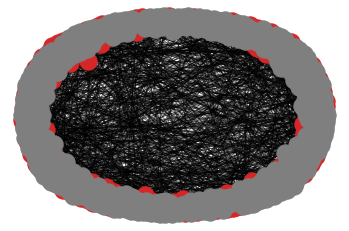

In [66]:
pos = nx.spring_layout(G,k=100, scale=10)  # positions for all nodes

nx.draw_networkx_nodes(G,pos,nodelist=nodeList_O,node_color="tab:red")
nx.draw_networkx_nodes(G,pos,nodelist=nodeList_H,node_color="tab:gray")
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

plt.axis("off")
plt.show()

In [68]:
rACClist,convergenceData = rACC(G)

(0.08, 0.1)

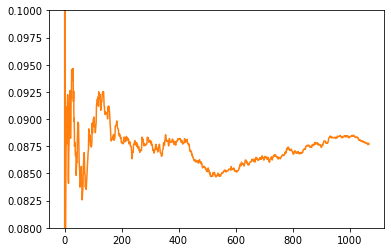

In [71]:
plt.plot(convergenceData)
plt.plot(rACClist)
plt.ylim((0.08, 0.1)) 

In [74]:
G.nodes[0]

{'label': 'O0', 'node_color': 'tab:red'}

In [86]:
import json
from networkx.readwrite import json_graph

f = open("savedGraph.json","w")
json.dump(json_graph.node_link_data(G), f, indent = 2)

f.close()

In [89]:
f = open("savedGraph.json")
H = json_graph.node_link_graph(json.load(f))


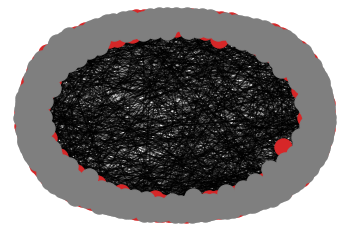

In [90]:
pos = nx.spring_layout(H,k=100, scale=10)  # positions for all nodes

nx.draw_networkx_nodes(H,pos,nodelist=nodeList_O,node_color="tab:red")
nx.draw_networkx_nodes(H,pos,nodelist=nodeList_H,node_color="tab:gray")
nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.5)

plt.axis("off")
plt.show()